In [3]:
# Importations et réglage de la reproductibilité
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras import layers, Model, Input, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import gradio as gr

# Pour la reproductibilité
tf.random.set_seed(42)
np.random.seed(42)

In [1]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 29.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 86.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
pip install h5py


In [23]:
# Fonctions d'extraction et de chargement du dataset UTKFace
def extract_age_gender(filename):
    """Extrait l'âge et le genre du nom de fichier UTKFace."""
    parts = filename.split("_")
    age = int(parts[0])
    gender = int(parts[1])
    return age, gender

def load_dataset(image_folder):
    """Charge les chemins d'image et labels depuis le dossier UTKFace."""
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    image_paths = [os.path.join(image_folder, f) for f in image_files]
    ages, genders = zip(*[extract_age_gender(f) for f in image_files])
    return image_paths, list(ages), list(genders)

# Définir le chemin vers le dataset
DATA_DIR = "/kaggle/input/utkface-new/UTKFace"
image_paths, ages, genders = load_dataset(DATA_DIR)

# Mélanger les données
image_paths, ages, genders = shuffle(image_paths, ages, genders, random_state=42)

# Séparation en ensembles train et validation (80% / 20%)
train_paths, val_paths, train_ages, val_ages, train_genders, val_genders = train_test_split(
    image_paths, ages, genders, test_size=0.2, random_state=42
)

print("Nombre d'images d'entraînement :", len(train_paths))
print("Nombre d'images de validation   :", len(val_paths))

Nombre d'images d'entraînement : 18966
Nombre d'images de validation   : 4742


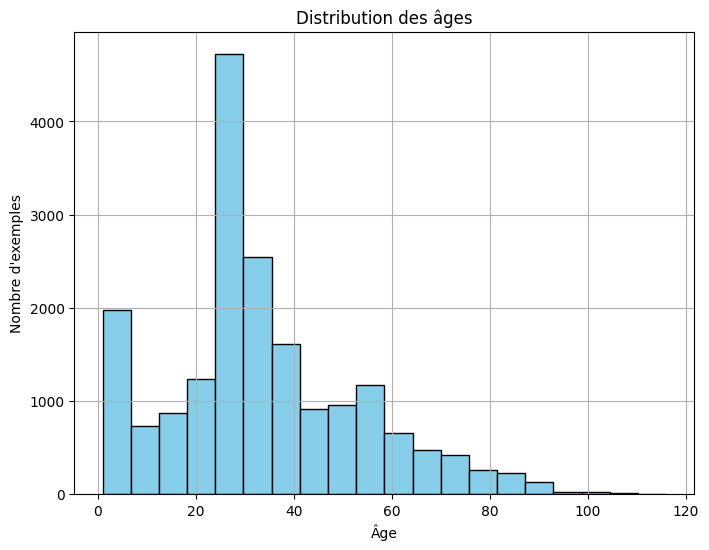

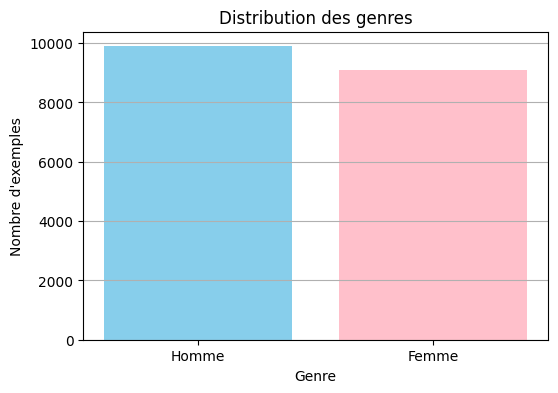

In [24]:
# Visualisation des distributions (utile pour comprendre le dataset)
def plot_age_distribution(ages):
    plt.figure(figsize=(8, 6))
    plt.hist(ages, bins=20, color='skyblue', edgecolor='black')
    plt.title("Distribution des âges")
    plt.xlabel("Âge")
    plt.ylabel("Nombre d'exemples")
    plt.grid(True)
    plt.show()

def plot_gender_distribution(genders):
    gender_labels = ["Homme", "Femme"]
    counts = [genders.count(0), genders.count(1)]
    plt.figure(figsize=(6, 4))
    plt.bar(gender_labels, counts, color=['skyblue', 'pink'])
    plt.title("Distribution des genres")
    plt.xlabel("Genre")
    plt.ylabel("Nombre d'exemples")
    plt.grid(axis='y')
    plt.show()

plot_age_distribution(train_ages)
plot_gender_distribution(train_genders)

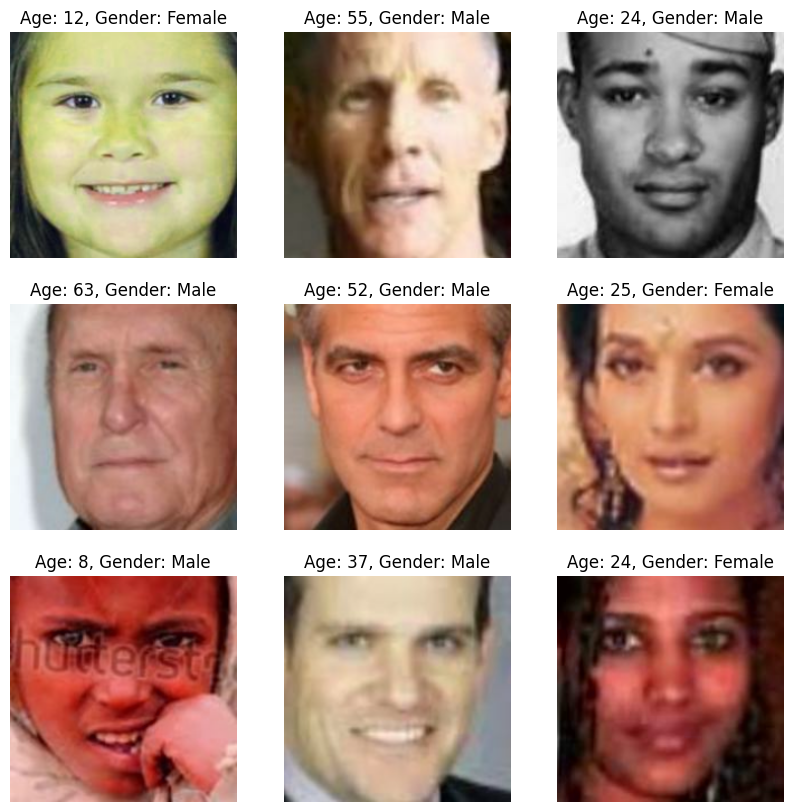

In [25]:
# --- Fonctions de prétraitement ---
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

def process_path_train(path, age, gender, image_size=IMAGE_SIZE):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)
    image = efficientnet_preprocess(image)
    normalized_age = tf.cast(age, tf.float32) / 116.0
    return image, {'age_output': normalized_age, 'gender_output': tf.cast(gender, tf.float32)}

def process_path_val(path, age, gender, image_size=IMAGE_SIZE):
    """Prétraitement pour la validation avec EfficientNet preprocessing (sans augmentation)."""
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = efficientnet_preprocess(image) 
    normalized_age = tf.cast(age, tf.float32) / 116.0 # Normalization
    return image, {'age_output': normalized_age, 'gender_output': tf.cast(gender, tf.float32)}

# --- Création des datasets ---
def create_dataset(paths, ages, genders, process_func, batch_size=BATCH_SIZE, shuffle_buffer=1000):
    ds = tf.data.Dataset.from_tensor_slices((paths, ages, genders))
    ds = ds.map(lambda p, a, g: process_func(p, a, g, IMAGE_SIZE), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(shuffle_buffer) # Shuffle only for training dataset
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = create_dataset(train_paths, train_ages, train_genders, process_path_train)
val_ds = create_dataset(val_paths, val_ages, val_genders, process_path_val, shuffle_buffer=1) 

# --- Visualisation d'un batch pour vérifier le prétraitement ---
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9): # Display 9 images from the batch
        plt.subplot(3, 3, i + 1)
        image = tf.keras.preprocessing.image.array_to_img(images[i]) 
        plt.imshow(image)
        age = labels['age_output'][i].numpy() * 116
        gender = "Female" if labels['gender_output'][i].numpy() >= 0.5 else "Male"
        plt.title(f"Age: {age:.0f}, Gender: {gender}")
        plt.axis('off')
    plt.show()

In [ ]:
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

IMAGE_SIZE = (224, 224)
L2_FACTOR = 0.0005
DROPOUT_RATE = 0.3

# Input layer
input_tensor = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# EfficientNetB2 base model
base_model_efficientnet = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_model_efficientnet.trainable = True
for layer in base_model_efficientnet.layers[:100]:
    layer.trainable = False

# Custom classification head
x = base_model_efficientnet(input_tensor)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=l2(L2_FACTOR))(x)
x = layers.Dropout(DROPOUT_RATE)(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=l2(L2_FACTOR))(x)
x = layers.Dropout(DROPOUT_RATE)(x)

# Couche partagée
shared = layers.Dense(256, activation='relu', kernel_regularizer=l2(L2_FACTOR))(x)
shared = layers.Dropout(DROPOUT_RATE)(shared)

# Branche âge
age_branch = layers.Dense(128, activation='relu', kernel_regularizer=l2(L2_FACTOR))(shared)
age_branch = layers.Dropout(DROPOUT_RATE)(age_branch)
age_output = layers.Dense(1, activation='relu', name='age_output')(age_branch)

# Branche genre
gender_branch = layers.Dense(128, activation='relu', kernel_regularizer=l2(L2_FACTOR))(shared)
gender_branch = layers.Dropout(DROPOUT_RATE)(gender_branch)
gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(gender_branch)

# Création du modèle
model_efficientnetB2 = Model(inputs=input_tensor, outputs=[age_output, gender_output])

# Résumé du modèle
model_efficientnetB2.summary()

# Compilation avec métriques supplémentaires
model_efficientnetB2.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss={'age_output': 'mae', 'gender_output': 'binary_crossentropy'},
    metrics={'age_output': ['mae', 'mse'], 'gender_output': ['accuracy', 'binary_accuracy']}
)

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler



callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint(filepath='/kaggle/working/checkpoints/model_efficientnetB2.keras', 
                    monitor='val_loss', save_best_only=True, verbose=1)
]

history_efficientnet = model_efficientnetB2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50, # Increased epochs
    callbacks=callbacks,

)

In [ ]:
model_efficientnetB2.save('/kaggle/working/model_efficientnetB2.h5', save_format='h5')


In [ ]:
model_efficientnetB2.save('/kaggle/working/model_efficientnetB2.keras')



In [32]:
# Visualisation des courbes d'apprentissage
def plot_training_curves(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['gender_output_accuracy'], label='Train Gender Accuracy')
    plt.plot(history.history['val_gender_output_accuracy'], label='Validation Gender Accuracy')
    plt.title('Gender Accuracy Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['age_output_mae'], label='Train Age MAE')
    plt.plot(history.history['val_age_output_mae'], label='Validation Age MAE', linestyle='dashed')
    plt.title('Evolution de la MAE pour l\'âge')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    
    plt.show()

    plt.tight_layout()
    plt.show()

plot_training_curves(history_efficientnet)

NameError: name 'history_efficientnet' is not defined

149/149 ━━━━━━━━━━━━━━━━━━━━ 24s 92ms/step - age_output_loss: 0.0474 - age_output_mean_absolute_error: 0.0474 - age_output_mean_squared_error: 0.0047 - gender_output_accuracy: 0.9395 - gender_output_binary_accuracy: 0.9395 - gender_output_loss: 0.2644 - loss: 0.3372
Validation Loss (Total): 0.360548734664917
Validation Age MAE: 0.04753424972295761
Validation Gender Accuracy: 0.9373682141304016
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/

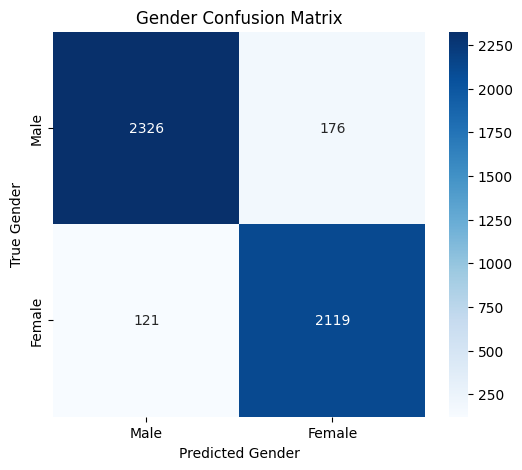

In [31]:
# Évaluation détaillée sur l'ensemble de validation
def evaluate_gender_performance(model, val_ds):
    """Evaluates gender classification and prints metrics."""
    true_genders = []
    predicted_genders_probs = []
    for images, labels in val_ds:
        true_genders.extend(labels['gender_output'].numpy())
        predicted_gender_probs_batch = model.predict(images)[1] # Index 1 for gender
        predicted_genders_probs.extend(predicted_gender_probs_batch.flatten())

    predicted_genders = np.round(predicted_genders_probs)
    true_genders = np.array(true_genders)
    predicted_genders = np.array(predicted_genders)

    print("\nConfusion Matrix:")
    cm = confusion_matrix(true_genders, predicted_genders)
    print(cm)

    print("\nClassification Report:")
    print(classification_report(true_genders, predicted_genders))

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
    plt.xlabel('Predicted Gender')
    plt.ylabel('True Gender')
    plt.title('Gender Confusion Matrix')
    plt.show()

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

results_val = model_efficientnetB2.evaluate(val_ds)
print("Validation Loss (Total):", results_val[0])
print("Validation Age MAE:", results_val[1])
print("Validation Gender Accuracy:", results_val[5]) # Index 4 for gender accuracy

evaluate_gender_performance(model_efficientnetB2, val_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━

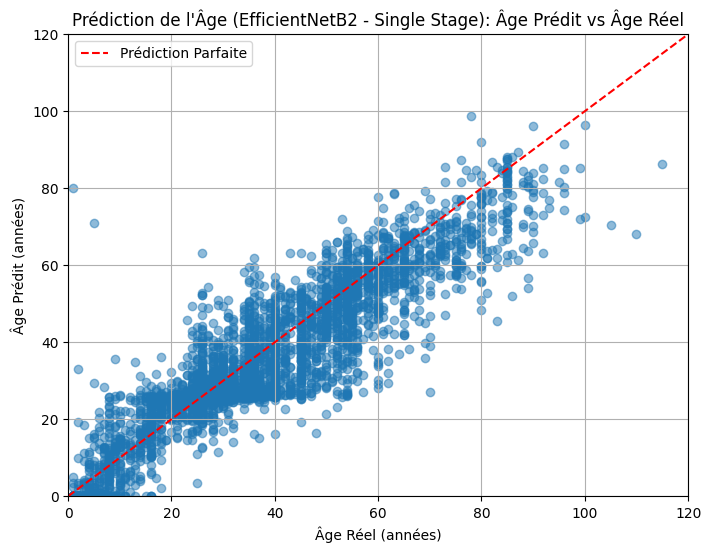

NameError: name 'inference_age_gender_from_path_v2' is not defined

<Figure size 2500x1000 with 0 Axes>

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
# Définir les objets personnalisés (custom_objects) pour charger le modèle
custom_objects = {"mae": MeanAbsoluteError(), "mse": MeanSquaredError()}

# Charger le modèle .h5 avec les objets personnalisés

model_efficientnetB2 = load_model(model_path, custom_objects=custom_objects)
evaluate_age_performance_efficient(model_efficientnetB2, val_ds, stage="Single Stage") 

num_images = 10
random_indices = np.random.choice(len(val_paths), num_images, replace=False)

plt.figure(figsize=(25, 10))  

# Boucle sur les indices sélectionnés
for i, idx in enumerate(random_indices):
    image_path = val_paths[idx]
    real_age = val_ages[idx]
    real_gender = "Female" if val_genders[idx] == 1 else "Male"
    
    # Prédire l'âge et le genre avec la fonction fournie
    predicted_age, predicted_gender = inference_age_gender_from_path_v2(
        model_efficientnetB2, image_path, image_size=IMAGE_SIZE, plot=False
    )
    
    # Charger et préparer l'image pour l'affichage
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    
    # Afficher l'image dans une grille 2x5
    plt.subplot(2, 5, i + 1)  # 2 lignes, 5 colonnes
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image))
    plt.title(f"Âge réel: {real_age}, Prédit: {predicted_age:.0f}\n"
              f"Genre réel: {real_gender}, Prédit: {predicted_gender}")
    plt.axis('off')

# Ajuster l'affichage et montrer la figure
plt.tight_layout()
plt.show()

In [28]:
def age_accuracy(y_true, y_pred, tol=5.0):
    """
    Calcule l'accuracy pour la prédiction de l'âge.
    On considère qu'une prédiction est correcte si l'erreur absolue
    (en années) est inférieure ou égale à tol (par défaut 5 ans).

    Les valeurs y_true et y_pred sont supposées être normalisées (ex : divisées par 120).
    """
    # Dénormalisation (si l'âge maximum est 120)
    y_true_denorm = y_true * 120.0
    y_pred_denorm = y_pred * 120.0
    # Calcul de la différence absolue
    diff = tf.abs(y_true_denorm - y_pred_denorm)
    # On considère la prédiction correcte si diff <= tol
    correct = tf.cast(tf.less_equal(diff, tol), tf.float32)
    # Retourne la proportion de prédictions correctes
    return tf.reduce_mean(correct)

print("age_accuracy function defined")

age_accuracy function defined



--- Évaluation de la Prédiction de l'Âge (EfficientNetB2 - Single Stage) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

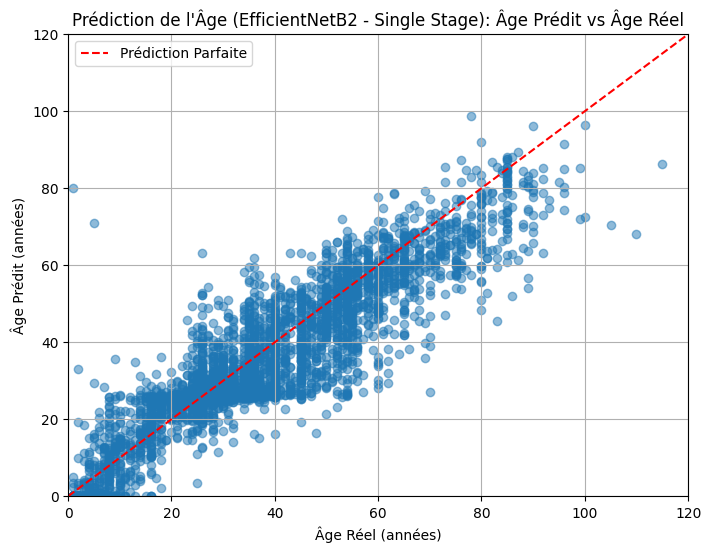

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix, classification_report

def evaluate_age_performance_efficient(model, val_ds, stage="Single Stage"): 
    """
    Évalue la performance de la prédiction de l'âge et affiche les métriques pour MobileNetV2.
    """
    true_ages = []
    predicted_ages_normalized = []

    for images, labels in val_ds:
        true_ages.extend(labels['age_output'].numpy())
        predicted_ages_batch_normalized = model.predict(images)[0] # Index 0 pour l'âge
        predicted_ages_normalized.extend(predicted_ages_batch_normalized.flatten())

    true_ages = np.array(true_ages) * 116.0  # Dénormaliser les âges réels
    predicted_ages = np.array(predicted_ages_normalized) * 116.0 # Dénormaliser les âges prédits

    # Calcul des métriques de régression
    mae = mean_absolute_error(true_ages, predicted_ages)
    mse = mean_squared_error(true_ages, predicted_ages)
    rmse = np.sqrt(mse)
    age_acc_10 = age_accuracy(true_ages / 120.0, predicted_ages / 120.0, tol=10.0).numpy() # Accuracy à 10 ans

    print(f"\nMétriques de Régression pour l'Âge (EfficientNetB2 - {stage}):")
    print(f"  Mean Absolute Error (MAE): {mae:.2f} years")
    print(f"  Mean Squared Error (MSE): {mse:.2f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"  Age Accuracy (within 10 years): {age_acc_10*100:.2f}%") # Accuracy à 10 ans

    # Graphique de dispersion (Scatter plot) : Prédit vs Réel
    plt.figure(figsize=(8, 6))
    plt.scatter(true_ages, predicted_ages, alpha=0.5)
    plt.plot([0, 120], [0, 120], linestyle='--', color='r', label='Prédiction Parfaite') # Ligne de référence pour prédiction parfaite
    plt.xlabel("Âge Réel (années)")
    plt.ylabel("Âge Prédit (années)")
    plt.title(f"Prédiction de l'Âge (EfficientNetB2 - {stage}): Âge Prédit vs Âge Réel")
    plt.xlim([0, 120]) # Limiter l'échelle pour la plage d'âge typique
    plt.ylim([0, 120])
    plt.legend()
    plt.grid(True)
    plt.show()


# Appel de la fonction d'évaluation de l'âge après l'évaluation du genre
print("\n--- Évaluation de la Prédiction de l'Âge (EfficientNetB2 - Single Stage) ---") 

# Définir les objets personnalisés (custom_objects) pour charger le modèle
custom_objects = {"mae": MeanAbsoluteError(), "mse": MeanSquaredError()}

# Charger le modèle .h5 avec les objets personnalisés

model_efficientnetB2 = load_model(model_path, custom_objects=custom_objects)
evaluate_age_performance_efficient(model_efficientnetB2, val_ds, stage="Single Stage") 

In [ ]:
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError # Import mse and mae

def evaluate_age_performance(model, val_dataset, stage="Validation"):
    """
    Évalue la performance de la prédiction de l'âge :
      - Calcul des métriques de régression (MAE, MSE, RMSE, accuracy within 5 & 10 ans)
      - Conversion des âges continus en classes d'âge et calcul de la confusion matrix.
    """
    true_ages = []
    pred_ages_norm = []
    
    # Collecte des prédictions
    for images, labels in val_dataset:
        true_ages.extend(labels['age_output'].numpy())
        preds = model.predict(images, verbose=0)[0]  # Prédictions de l'âge (en supprimant le verbose pour plus de clarté)
        pred_ages_norm.extend(preds.flatten())
    
    # Dénormalisation
    true_ages = np.array(true_ages) * 120.0
    pred_ages = np.array(pred_ages_norm) * 120.0
    
    # Métriques de régression
    mae = mean_absolute_error(true_ages, pred_ages)
    mse = mean_squared_error(true_ages, pred_ages)
    rmse = np.sqrt(mse)
    acc_5 = np.mean(np.abs(true_ages - pred_ages) <= 5.0)  # Simplification du calcul de l'accuracy
    acc_10 = np.mean(np.abs(true_ages - pred_ages) <= 10.0)
    
    print(f"\nMétriques de Régression pour l'Âge ({stage}):")
    print(f"  MAE : {mae:.2f} ans")
    print(f"  MSE : {mse:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  Accuracy within 5 ans: {acc_5*100:.2f}%")
    print(f"  Accuracy within 10 ans: {acc_10*100:.2f}%")
    
    # Définition des tranches d'âge
    age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120]
    age_labels = [f"{age_bins[i]}-{age_bins[i+1]-1}" for i in range(len(age_bins)-1)]
    
    # Classification des âges en tranches
    true_bin_indices = np.digitize(true_ages, age_bins) - 1
    pred_bin_indices = np.digitize(pred_ages, age_bins) - 1
    
    # Correction des indices hors limites
    true_bin_indices = np.clip(true_bin_indices, 0, len(age_labels)-1)
    pred_bin_indices = np.clip(pred_bin_indices, 0, len(age_labels)-1)
    
    # Conversion des indices en noms de classes
    true_bins = [age_labels[i] for i in true_bin_indices]
    pred_bins = [age_labels[i] for i in pred_bin_indices]
    
    # Matrice de confusion
    print("\n--- Évaluation par Classes d'Âge ---")
    cm = confusion_matrix(true_bins, pred_bins, labels=age_labels)
    print("Confusion matrix:")
    print(cm)
    
    # Visualisation de la matrice de confusion
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=age_labels, yticklabels=age_labels)
    plt.xlabel("Classe d'âge prédite")
    plt.ylabel("Classe d'âge réelle")
    plt.title(f"Confusion Matrix - Classes d'Âge ({stage})")
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_age_{stage.lower()}.png')
    plt.show()
    
    # Rapport de classification
    print("\nClassification Report (Classes d'Âge):")
    print(classification_report(true_bins, pred_bins, labels=age_labels, zero_division=0))
    
    # Scatter plot pour comparer les âges réels et prédits
    plt.figure(figsize=(10, 8))
    plt.scatter(true_ages, pred_ages, alpha=0.5)
    plt.plot([0, 120], [0, 120], linestyle='--', color='r', label='Prédiction Parfaite')
    
    # Ajout des lignes de tolérance pour ±5 ans et ±10 ans
    plt.plot([0, 120], [5, 125], linestyle=':', color='g', label='±5 ans')
    plt.plot([0, 120], [-5, 115], linestyle=':', color='g')
    plt.plot([0, 120], [10, 130], linestyle=':', color='b', label='±10 ans')
    plt.plot([0, 120], [-10, 110], linestyle=':', color='b')
    
    plt.xlabel("Âge Réel (années)")
    plt.ylabel("Âge Prédit (années)")
    plt.title(f"Prédiction de l'Âge ({stage})")
    plt.xlim([0, 120])
    plt.ylim([0, 120])
    plt.legend()
    plt.grid(True)
    plt.savefig(f'age_prediction_scatter_{stage.lower()}.png')
    plt.show()
    
    # Histogramme des erreurs
    errors = pred_ages - true_ages
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=30, alpha=0.7)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.axvline(x=5, color='g', linestyle=':', label='+5 ans')
    plt.axvline(x=-5, color='g', linestyle=':', label='-5 ans')
    plt.axvline(x=10, color='b', linestyle=':', label='+10 ans')
    plt.axvline(x=-10, color='b', linestyle=':', label='-10 ans')
    plt.xlabel("Erreur de prédiction (années)")
    plt.ylabel("Nombre d'échantillons")
    plt.title(f"Distribution des erreurs de prédiction d'âge ({stage})")
    plt.legend()
    plt.grid(True)
    plt.savefig(f'age_error_distribution_{stage.lower()}.png')
    plt.show()
    
    return mae, acc_5, acc_10, cm
model_path = '/kaggle/input/effimodelb2/tensorflow2/default/1/model_efficientnetB2.h5'

# Définir les objets personnalisés (custom_objects) pour charger le modèle
custom_objects = {"mae": MeanAbsoluteError(), "mse": MeanSquaredError()}

# Charger le modèle .h5 avec les objets personnalisés

model_efficientnetB2 = load_model(model_path, custom_objects=custom_objects)
evaluate_age_performance(model_efficientnetB2, val_ds, stage="Validation")

In [ ]:
import gradio as gr
import tensorflow as tf
import numpy as np

# Fonction d'inférence (inchangée)
def gradio_inference(img):
    """Gradio wrapper function for interactive inference."""
    img_array = np.array(img)
    img_resized = tf.image.resize(img_array, IMAGE_SIZE)
    img_preprocessed = efficientnet_preprocess(img_resized)
    input_tensor = tf.expand_dims(img_preprocessed, axis=0)
    predictions = model_efficientnett_v2.predict(input_tensor)
    pred_age = predictions[0][0][0] * 120
    pred_gender_prob = predictions[1][0][0]
    gender_label = "Female" if pred_gender_prob >= 0.5 else "Male"
    return f"Predicted Age: {pred_age:.0f} years, Predicted Gender: {gender_label}"

# Interface Gradio avec un design amélioré
with gr.Blocks(theme=gr.themes.Soft()) as iface:
    gr.Markdown(
        """
        # Age and Gender Prediction
        Upload a face image to predict age and gender using EfficientNetB2.

        **How to use:**  
        1. Click on the image upload area below.  
        2. Select an image from your device.  
        3. Click "Predict" to see the results.
        """
    )
    
    with gr.Row():
        with gr.Column(scale=1):
            img_input = gr.Image(type="pil", label="Upload Face Image")
            submit_btn = gr.Button("Predict")
            reset_btn = gr.Button("Reset")
        
        with gr.Column(scale=1):
            output_text = gr.Textbox(label="Prediction", interactive=False)
    
    # Fonctionnalité de réinitialisation
    def reset():
        return None, ""
    
    # Lier les boutons aux fonctions
    submit_btn.click(
        fn=gradio_inference, 
        inputs=img_input, 
        outputs=output_text, 
        show_progress=True  # Indicateur de chargement
    )
    
    reset_btn.click(
        fn=reset, 
        inputs=None, 
        outputs=[img_input, output_text]
    )

# Lancer l'interface
iface.launch(share=True)

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("/kaggle/input/eficient/tensorflow2/default/1/efficientnetB294 (1).h5")


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import os
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess

# Ton modèle (remplace par le tien)
model = model_efficientnetB2

utkface_path = "/kaggle/input/utkface-new/UTKFace/"
img_height, img_width = 224, 224
image_files = [f for f in os.listdir(utkface_path) if f.endswith('.jpg.chip.jpg')]

def preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Erreur: {img_path} non chargé")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_height, img_width))
    img_array = np.expand_dims(img, axis=0)
    return efficientnet_preprocess(img_array)  # Prétraitement EfficientNet

def extract_info(filename):
    parts = filename.split('_')
    age, gender = int(parts[0]), int(parts[1])  # 0 = Masculin, 1 = Féminin
    return age, gender

for image_file in image_files[:5]:  # Test sur 5 images
    image_path = os.path.join(utkface_path, image_file)
    processed_image = preprocess_image(image_path)
    if processed_image is None:
        continue

    predictions = model_efficientnetB2.predict(processed_image)

    if isinstance(predictions, list) and len(predictions) == 2:
        # Correction : Extraction correcte des prédictions
        pred_age = predictions[0][0][0] * 120  # Ajuste selon ton dataset
        pred_gender_prob = predictions[1][0][0]  # Probabilité d'être une femme

        # Détermination du sexe
        predicted_gender = "Féminin" if pred_gender_prob >= 0.5 else "Masculin"
        predicted_age = int(round(pred_age))  # Conversion en âge entier

        # Affichage des résultats
        true_age, true_gender = extract_info(image_file)
        print(f"Image: {image_file}")
        print(f"  Sexe prédit: {predicted_gender}, Âge prédit: {predicted_age}")
        print(f"  Réel: Âge: {true_age}, Sexe: {'Masculin' if true_gender == 0 else 'Féminin'}")
        print(f"  Probabilité genre: {pred_gender_prob:.4f}, Valeur brute âge: {pred_age:.4f}")
        print("-" * 30)
    else:
        print(f"⚠️ Erreur: Structure inattendue pour {image_file}. Vérifie le modèle.")


Modèle chargé avec succès depuis : /kaggle/input/effimodelb2/tensorflow2/default/1/model_efficientnetB2.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


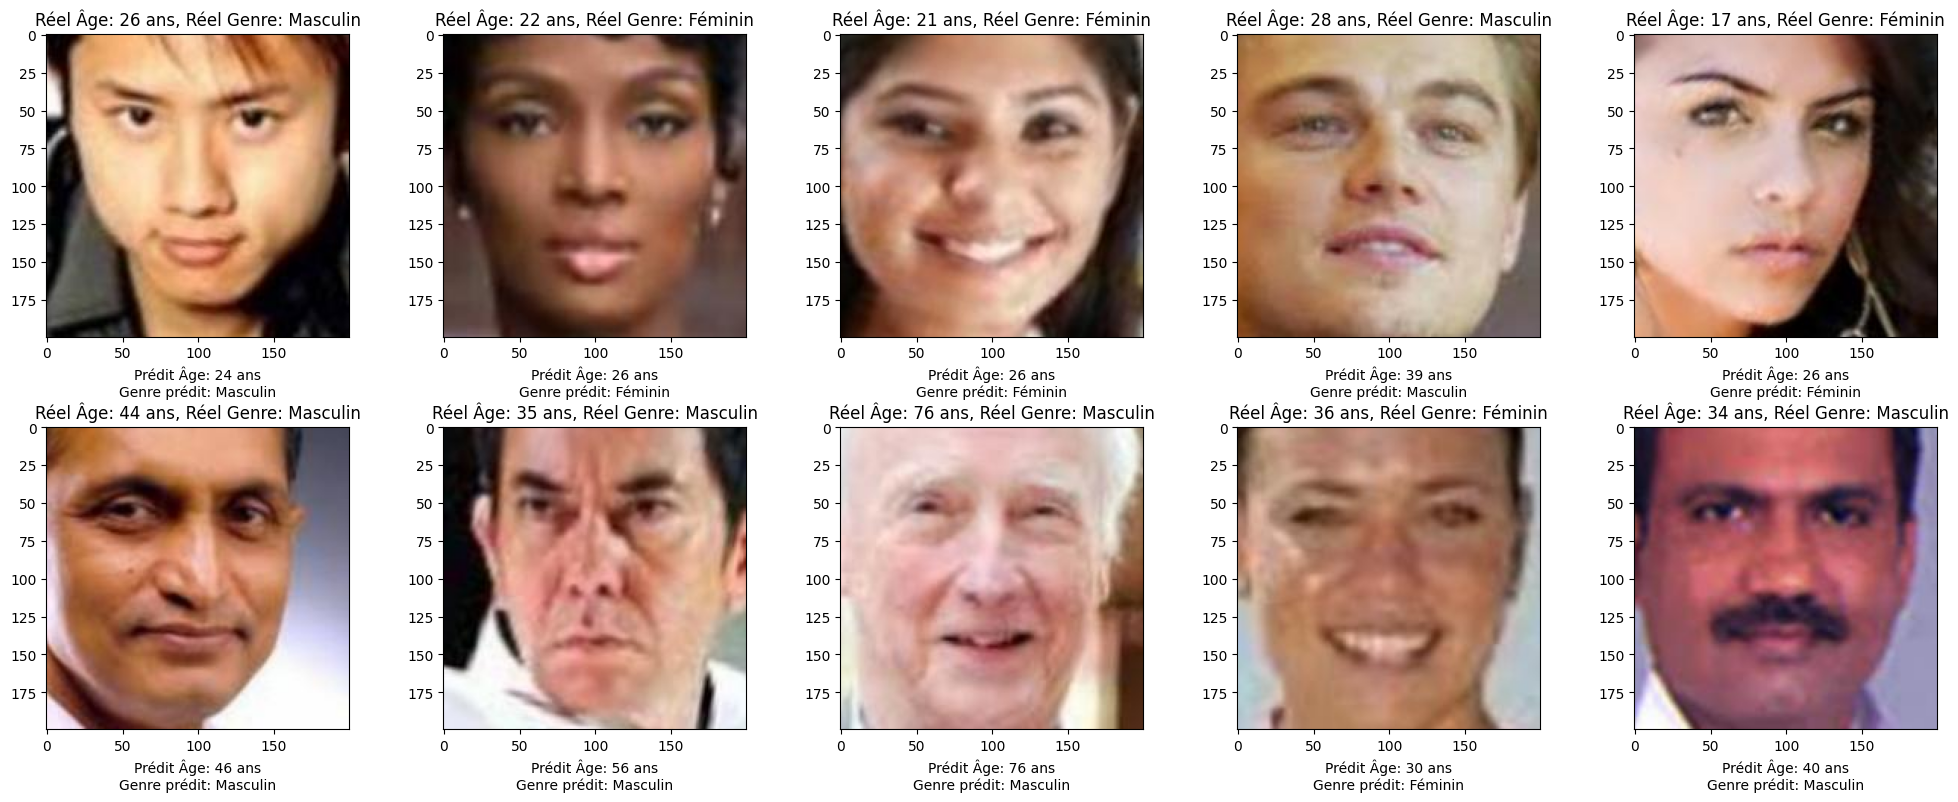

In [21]:
import os
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError # Import mse and mae
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
import matplotlib.pyplot as plt # Import matplotlib

# Définir le chemin vers le modèle .h5
model_path = '/kaggle/input/effimodelb2/tensorflow2/default/1/model_efficientnetB2.h5'

# Définir les objets personnalisés (custom_objects) pour charger le modèle
custom_objects = {"mae": MeanAbsoluteError(), "mse": MeanSquaredError()}

# Charger le modèle .h5 avec les objets personnalisés
try:
    model_efficientnetB2 = load_model(model_path, custom_objects=custom_objects)
    print(f"Modèle chargé avec succès depuis : {model_path}")
except Exception as e:
    print(f"Erreur lors du chargement du modèle : {e}")
    model_efficientnetB2 = None

if model_efficientnetB2 is not None:
    image_folder = '/kaggle/input/utkface-new/UTKFace'
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]

    img_height, img_width = 224, 224

    def preprocess_image(img_path):
        img = cv2.imread(img_path)
        if img is None:
            print(f"Erreur: {img_path} non chargé")
            return None
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Keep original image in RGB for display
        img_resized = cv2.resize(img_rgb, (img_height, img_width))
        img_array = np.expand_dims(img_resized, axis=0)
        processed_img = efficientnet_preprocess(img_array)
        return processed_img, img_rgb # Return both processed and original RGB image

    def extract_real_age_gender(filename):
        """Extracts real age and gender from the filename."""
        try:
            parts = filename.split('_')
            age = int(parts[0])
            gender_code = int(parts[1])
            gender = "Féminin" if gender_code == 1 else "Masculin" # Assuming 0:Male, 1:Female
            return age, gender
        except:
            return "N/A", "N/A" # Return "N/A" for both if extraction fails

    num_images_to_display = 10 # Display 10 images
    plt.figure(figsize=(20, 8)) # Adjust figure size for 2x5 grid

    for i, img_file in enumerate(image_files[:num_images_to_display]): # Limiter à num_images_to_display
        img_path = os.path.join(image_folder, img_file)
        processed_image, original_image_rgb = preprocess_image(img_path) # Get both processed and original image
        real_age, real_gender = extract_real_age_gender(img_file) # Extract real age and gender from filename

        if processed_image is not None: # Vérifier si l'image a été prétraitée avec succès
            try:
                # Prédiction avec le modèle EfficientNetB2 chargé
                predictions = model_efficientnetB2.predict(processed_image)

                # Si le modèle a deux sorties (âge et genre), predictions est une liste
                if isinstance(predictions, list) and len(predictions) == 2:
                    age_pred = predictions[0][0][0]  # Âge prédit (premier élément du batch)
                    gender_pred = predictions[1][0][0]  # Probabilité de genre

                    predicted_age = int(np.round(age_pred * 116))  # Dé-normalisation de l’âge
                    predicted_gender = "Féminin" if gender_pred > 0.5 else "Masculin"
                    prediction_text_title = f"Réel Âge: {real_age} ans, Réel Genre: {real_gender}" # All info in title
                else:
                    prediction_text_title = f"Structure inattendue des prédictions"
                    print(f" Structure inattendue des prédictions: {predictions}")
                    print("  **Vérifiez la structure de sortie de votre modèle avec model_efficientnetB2.summary()**")
                    predicted_gender = "N/A" # Placeholder for gender in case of error
                    predicted_age = "N/A"    # Placeholder for age in case of error

            except Exception as e:
                prediction_text_title = f"Erreur lors de la prédiction: {e}"
                print(f"Erreur lors de la prédiction pour {img_file}: {e}")
                predicted_gender = "Error" # Placeholder for gender in case of error
                predicted_age = "Error"    # Placeholder for age in case of error

            plt.subplot(2, 5, i + 1) # Create subplots in 2 rows and 5 columns
            plt.imshow(original_image_rgb) # Display original RGB image
            plt.title(f"Image: {img_file}, {prediction_text_title}") # Set title with all info
            plt.title(f"Réel Âge: {real_age} ans, Réel Genre: {real_gender}")  # Réels au-dessus
            plt.xlabel(f"Prédit Âge: {predicted_age} ans\nGenre prédit: {predicted_gender}")  # Prédits en-dessous            plt.axis('off') # Hide axes for cleaner display

        else:
            print(f"Impossible de traiter l'image : {img_file}")

    plt.tight_layout() # Adjust layout to prevent titles from overlapping
    plt.show()

else:
    print("Le modèle n'a pas pu être chargé. Veuillez vérifier le chemin et les objets personnalisés.")

In [ ]:
predictions = model_efficientnett_v2.predict(image)
age_pred, gender_pred = predictions[0][0], predictions[1][0]
print(f"Probabilité genre: {gender_pred}, Valeur brute âge: {age_pred}")